In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.autograd import Variable # variables may accumulate gradients
from sklearn.model_selection import train_test_split
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")

import os
print(os.listdir("./data/kaggle1"))

# generic training function
def train_(model, resize, #  e.g. lambda x : x.view(-1, 28)
            optimizer, error,
            train_loader, test_loader,
            batch_size, n_iters, n_epochs):
    
    count = 0
    loss_list = []
    iteration_list = []
    accuracy_list = []
    
    for epoch in range(n_epochs):
        for i, (images, labels) in enumerate(train_loader):

            # Define variables
            train = resize(images) # create a column tensor

            # Clear gradients
            optimizer.zero_grad()

            # Forward propagation
            outputs = model(train)

            # Calculate softmax and cross entropy loss
            loss = error(outputs, labels)

            # Calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

            count += 1

            # Prediction
            if count % 50 == 0:
                # Calculate Accuracy         
                correct = 0
                total = 0
                # Predict test dataset
                for images, labels in test_loader: 
                    test = resize(images)

                    # Forward propagation
                    outputs = model(test)

                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]

                    # Total number of labels
                    total += len(labels)

                    # Total correct predictions
                    correct += (predicted == labels).sum()

                accuracy = 100 * correct / float(total)
                loss_list.append(loss.data)
                iteration_list.append(count)
                accuracy_list.append(accuracy)

                if count % 500 == 0:
                    # Print Loss
                    print('Epoch: {}  Iteration: {}  Loss: {}  Accuracy: {}%'.format(epoch,
                                                                                     count,
                                                                                     loss.data,
                                                                                     accuracy))
    return(model, {'loss_list' : loss_list,
                   'accuracy_list' : accuracy_list,
                   'iteration_list' : iteration_list})

# generic plot func
def measures_plot(measures):
    plt.plot(measures['iteration_list'], measures['loss_list'])
    plt.xlabel("Number of iteration")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.show()

    plt.plot(measures['iteration_list'], measures['accuracy_list'], color = "red")
    plt.xlabel("Number of iteration")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.show()

['sample_submission.csv', 'test.csv', 'train.csv']


Hand-written digit classification

In [2]:
# load data
train = pd.read_csv(r"./data/kaggle1/train.csv", dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42)

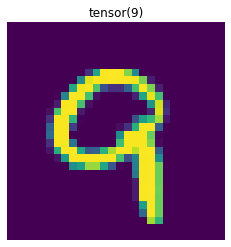

In [3]:
# create feature and targets tensor for train set.
# We need variable to accumulate gradients.
# Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is Long
# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is Long

# Pytorch train and test sets
train_set = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test_set = torch.utils.data.TensorDataset(featuresTest,targetsTest)

height = 28
width = 28
n_pixels = height*width
n_classes = 10 # labels 0,1,2,3,4,5,6,7,8,9

# visualize one of the images in data set
plt.imshow(featuresTrain[10].reshape(height, width))
plt.axis("off")
plt.title(str(targetsTrain[10]))
plt.savefig('graph.png')
plt.show()

In [4]:
# Create Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        # Linear part
        self.linear = nn.Linear(input_dim, output_dim)
        # Logistic function in pytorch is in loss function - comes later
    
    def forward(self, x):
        out = self.linear(x)
        return out

# Instantiate Model
model = LogisticRegressionModel(input_dim=n_pixels, output_dim=n_classes)

Epoch: 1  Iteration: 500  Loss: 0.6227263808250427  Accuracy: 86.30952453613281%
Epoch: 2  Iteration: 1000  Loss: 0.3905898630619049  Accuracy: 87.61904907226562%
Epoch: 4  Iteration: 1500  Loss: 0.4230879843235016  Accuracy: 88.4047622680664%
Epoch: 5  Iteration: 2000  Loss: 0.3496244549751282  Accuracy: 88.8452377319336%
Epoch: 7  Iteration: 2500  Loss: 0.4150945246219635  Accuracy: 89.25%
Epoch: 8  Iteration: 3000  Loss: 0.5229318141937256  Accuracy: 89.55952453613281%
Epoch: 10  Iteration: 3500  Loss: 0.330695241689682  Accuracy: 89.80952453613281%
Epoch: 11  Iteration: 4000  Loss: 0.42919254302978516  Accuracy: 90.07142639160156%
Epoch: 13  Iteration: 4500  Loss: 0.37618952989578247  Accuracy: 90.1547622680664%
Epoch: 14  Iteration: 5000  Loss: 0.35281264781951904  Accuracy: 90.20237731933594%
Epoch: 16  Iteration: 5500  Loss: 0.2069907933473587  Accuracy: 90.23809814453125%
Epoch: 17  Iteration: 6000  Loss: 0.254111111164093  Accuracy: 90.36904907226562%
Epoch: 19  Iteration: 650

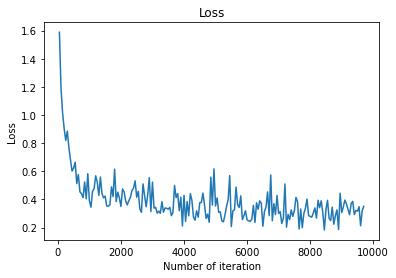

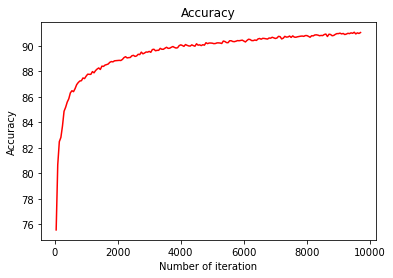

In [5]:
batch_size = 100
n_iters = 10000

# data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True)

# Cross Entropy Loss  
error = nn.CrossEntropyLoss()

# SGD Optimizer 
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model, measures = train_(model, resize = lambda x : x.view(-1, n_pixels), # this will convert each instance to a column vec
                         optimizer = optimizer, error = error,
                         train_loader = train_loader,
                         test_loader = test_loader,
                         batch_size = batch_size,
                         n_iters = n_iters,
                         n_epochs = int(n_iters / (len(features_train) / batch_size)))

measures_plot(measures)

In [6]:
# Create ANN Model
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
        # Linear function 1: 784 --> 100
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity 1
        self.relu1 = nn.ReLU()
        
        # Linear function 2: 100 --> 100
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2
        self.tanh2 = nn.Tanh()
        
        # Linear function 3: 100 --> 100
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3
        self.elu3 = nn.ELU()
        
        # Linear function 4 (readout): 100 --> 10
        self.fc4 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)
        
        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.tanh2(out)
        
        # Linear function 2
        out = self.fc3(out)
        # Non-linearity 2
        out = self.elu3(out)
        
        # Linear function 4 (readout)
        out = self.fc4(out)
        return out

# instantiate ANN
input_dim = n_pixels
hidden_dim = 100 # to be tuned as a hyper-param
output_dim = n_classes

# Create ANN
model = ANNModel(input_dim, hidden_dim, output_dim)

Epoch: 1  Iteration: 500  Loss: 0.8401006460189819  Accuracy: 75.75%
Epoch: 2  Iteration: 1000  Loss: 0.5060939192771912  Accuracy: 87.48809814453125%
Epoch: 4  Iteration: 1500  Loss: 0.39330315589904785  Accuracy: 89.61904907226562%
Epoch: 5  Iteration: 2000  Loss: 0.3368932008743286  Accuracy: 90.77381134033203%
Epoch: 7  Iteration: 2500  Loss: 0.22129271924495697  Accuracy: 91.54762268066406%
Epoch: 8  Iteration: 3000  Loss: 0.2867303192615509  Accuracy: 92.64286041259766%
Epoch: 10  Iteration: 3500  Loss: 0.1742410510778427  Accuracy: 93.10713958740234%
Epoch: 11  Iteration: 4000  Loss: 0.19321641325950623  Accuracy: 93.71428680419922%
Epoch: 13  Iteration: 4500  Loss: 0.09238127619028091  Accuracy: 94.19047546386719%
Epoch: 14  Iteration: 5000  Loss: 0.29674220085144043  Accuracy: 94.51190185546875%
Epoch: 16  Iteration: 5500  Loss: 0.09219080209732056  Accuracy: 94.75%
Epoch: 17  Iteration: 6000  Loss: 0.1405213475227356  Accuracy: 94.67857360839844%
Epoch: 19  Iteration: 6500  L

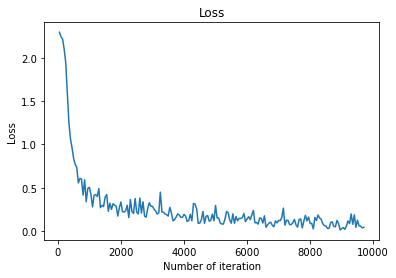

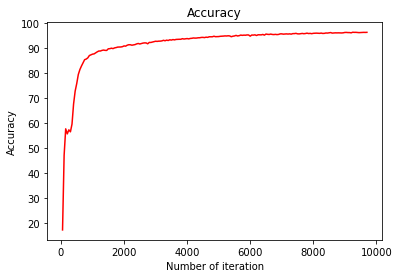

In [7]:
batch_size = 100
n_iters = 10000

# data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True)

# Cross Entropy Loss  
error = nn.CrossEntropyLoss()

# SGD Optimizer 
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model, measures = train_(model, resize = lambda x : x.view(-1, n_pixels), # this will convert each instance to a column vec
                         optimizer = optimizer, error = error,
                         train_loader = train_loader,
                         test_loader = test_loader,
                         batch_size = batch_size,
                         n_iters = n_iters,
                         n_epochs = int(n_iters / (len(features_train) / batch_size)))

measures_plot(measures)

In [8]:
# using nn.Sequential
hidden1_dim = 60
hidden2_dim = 40
hidden3_dim = 20

def add_layer(input_dim, output_dim, activation='relu'):
    activations = nn.ModuleDict([
        ['sig', nn.Sigmoid()],
        ['tanh', nn.Tanh()],
        ['lrelu', nn.LeakyReLU()],
        ['relu', nn.ReLU()],
        ['elu', nn.ELU()]
    ])
    
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        activations[activation]
    )

model = nn.Sequential(
    add_layer(n_pixels, hidden1_dim, 'relu'),
    add_layer(hidden1_dim, hidden2_dim, 'tanh'),
    add_layer(hidden2_dim, hidden3_dim, 'elu'),
    nn.Linear(hidden3_dim, n_classes)
    )

Epoch: 1  Iteration: 500  Loss: 1.196709394454956  Accuracy: 69.6547622680664%
Epoch: 2  Iteration: 1000  Loss: 0.5904291868209839  Accuracy: 85.32142639160156%
Epoch: 4  Iteration: 1500  Loss: 0.5969209671020508  Accuracy: 88.79762268066406%
Epoch: 5  Iteration: 2000  Loss: 0.29512253403663635  Accuracy: 90.10713958740234%
Epoch: 7  Iteration: 2500  Loss: 0.38657042384147644  Accuracy: 91.21428680419922%
Epoch: 8  Iteration: 3000  Loss: 0.22616660594940186  Accuracy: 91.88095092773438%
Epoch: 10  Iteration: 3500  Loss: 0.2383737564086914  Accuracy: 92.53571319580078%
Epoch: 11  Iteration: 4000  Loss: 0.12956009805202484  Accuracy: 93.17857360839844%
Epoch: 13  Iteration: 4500  Loss: 0.17965644598007202  Accuracy: 93.51190185546875%
Epoch: 14  Iteration: 5000  Loss: 0.17056268453598022  Accuracy: 93.88095092773438%
Epoch: 16  Iteration: 5500  Loss: 0.17881423234939575  Accuracy: 94.57142639160156%
Epoch: 17  Iteration: 6000  Loss: 0.14774459600448608  Accuracy: 94.9047622680664%
Epoch:

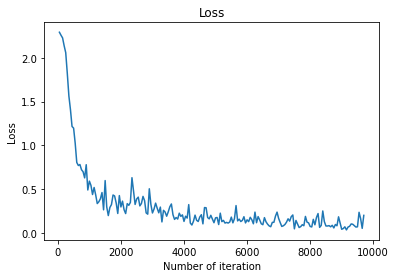

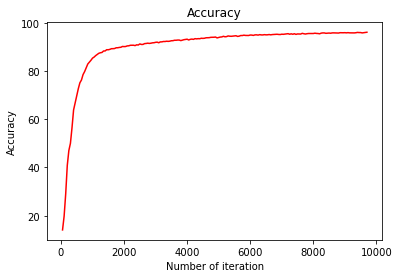

In [9]:
batch_size = 100
n_iters = 10000

# data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True)

# Cross Entropy Loss  
error = nn.CrossEntropyLoss()

# SGD Optimizer 
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model, measures = train_(model, resize = lambda x : x.view(-1, n_pixels), # this will convert each instance to a column vec
                         optimizer = optimizer, error = error,
                         train_loader = train_loader,
                         test_loader = test_loader,
                         batch_size = batch_size,
                         n_iters = n_iters,
                         n_epochs = int(n_iters / (len(features_train) / batch_size)))

measures_plot(measures)

In [10]:
mpk = 2

def conv_block(in_f, out_f, activation, *args, **kwargs):
    activations = nn.ModuleDict([
        ['sig', nn.Sigmoid()],
        ['tanh', nn.Tanh()],
        ['lrelu', nn.LeakyReLU()],
        ['relu', nn.ReLU()],
        ['elu', nn.ELU()]
    ])
    return nn.Sequential(
        nn.Conv2d(in_f, out_f, *args, **kwargs),
        activations[activation],
        nn.MaxPool2d(kernel_size=mpk)
    )

class CNN(nn.Module):
    def __init__(self, in_c, enc_sizes, activations, n_classes):
        super(CNN, self).__init__()

        self.enc_sizes = [in_c, *enc_sizes]
        
        #         self.encoder = nn.Sequential(
        #             conv_block(1, 16, kernel_size=5, stride=1, padding=0),
        #             conv_block(16, 32, kernel_size=5, stride=1, padding=0)
        #         )
        conv_blocks = [conv_block(in_f, out_f, act, kernel_size=5, stride=1, padding=0) 
                       for in_f, out_f, act in zip(self.enc_sizes, self.enc_sizes[1:], activations)]
        
        self.encoder = nn.Sequential(*conv_blocks)
        
        self.decoder = nn.Sequential(
            # * 4 * 4 is from two lots of max pooling kernel size 2
            # base value should match last channel size
            nn.Linear(enc_sizes[len(enc_sizes)-1] * 4 * 4, n_classes)
        )
        
    def forward(self, x):
        out = self.encoder(x)
        out = out.view(out.size(0), -1)
        out = self.decoder(out)
        return(out)

# Create ANN
model = CNN(in_c=1, enc_sizes=[16, 32], activations=['relu', 'elu'], n_classes=n_classes)

Epoch: 1  Iteration: 500  Loss: 0.349287748336792  Accuracy: 91.47618865966797%
Epoch: 2  Iteration: 1000  Loss: 0.1476392149925232  Accuracy: 94.73809814453125%
Epoch: 4  Iteration: 1500  Loss: 0.15224406123161316  Accuracy: 95.52381134033203%
Epoch: 5  Iteration: 2000  Loss: 0.06160472705960274  Accuracy: 96.66666412353516%


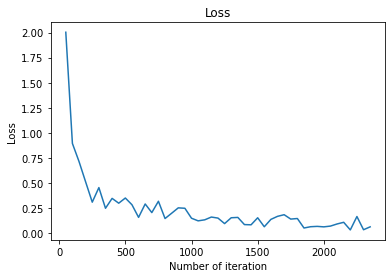

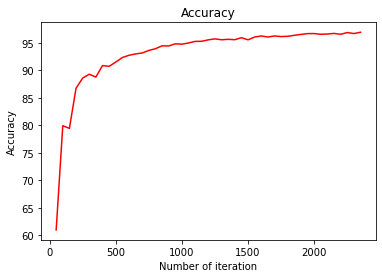

In [11]:
batch_size = 100
n_iters = 2500

# data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True)

# Cross Entropy Loss  
error = nn.CrossEntropyLoss()

# SGD Optimizer 
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model, measures = train_(model, resize = lambda x : x.view(-1,1,28,28), # this will convert each instance to a column vec
                         optimizer = optimizer, error = error,
                         train_loader = train_loader,
                         test_loader = test_loader,
                         batch_size = batch_size,
                         n_iters = n_iters,
                         n_epochs = int(n_iters / (len(features_train) / batch_size)))

measures_plot(measures)

In [12]:
# Create RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, 
                          nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
            
        # One time step
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out

# Create RNN
input_dim = 28    # input dimension - use the pixel width for square images
hidden_dim = 100  # hidden layer dimension
layer_dim = 3   # number of hidden layers

model = RNNModel(input_dim, hidden_dim, layer_dim, n_classes)

Epoch: 1  Iteration: 500  Loss: 2.1469109058380127  Accuracy: 29.535715103149414%
Epoch: 2  Iteration: 1000  Loss: 0.7088332176208496  Accuracy: 68.94047546386719%
Epoch: 4  Iteration: 1500  Loss: 0.6969566941261292  Accuracy: 76.04762268066406%
Epoch: 5  Iteration: 2000  Loss: 0.39206889271736145  Accuracy: 90.88095092773438%
Epoch: 7  Iteration: 2500  Loss: nan  Accuracy: 9.714285850524902%
Epoch: 8  Iteration: 3000  Loss: nan  Accuracy: 9.714285850524902%
Epoch: 10  Iteration: 3500  Loss: nan  Accuracy: 9.714285850524902%
Epoch: 11  Iteration: 4000  Loss: nan  Accuracy: 9.714285850524902%


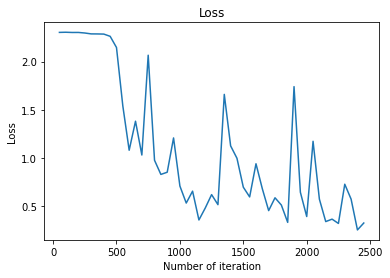

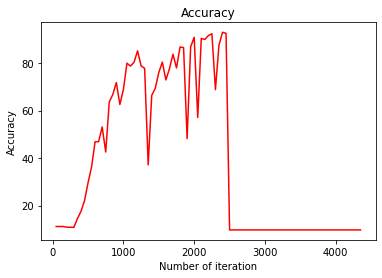

In [13]:
batch_size = 100
n_iters = 4500

# data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer 
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model, measures = train_(model, resize = lambda x : x.view(-1, width, width), 
                         optimizer = optimizer, error = error,
                         train_loader = train_loader,
                         test_loader = test_loader,
                         batch_size = batch_size,
                         n_iters = n_iters,
                         n_epochs = int(n_iters / (len(features_train) / batch_size)))

measures_plot(measures)